In [2]:
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, grad, vmap
import optax


import pickle as pkl

import itertools
import more_itertools as mit

import os

from alive_progress import alive_bar
import gc

import matplotlib.pyplot as plt

parallel_scan = jax.lax.associative_scan

### Dataset with 5 symbols, of 8-FSK with symbol duration of 1 sec and a samplingrate of 20 kHz

In [3]:
# generate dataset
sampling_rate = int(20e3)
duration = 5 
symbol_duration = 1
n_samples = sampling_rate * duration
symbol_samples = sampling_rate * symbol_duration
t = jnp.linspace(0, symbol_duration, symbol_samples, endpoint=False)
frequnecies = jnp.arange(0, 10e3, 1250)
relative_frequency_offset = 0.01
frequency_offset = relative_frequency_offset * frequnecies
samples = int(sampling_rate)
SNR = 15

# Chose five random frequencies
np.random.seed(0)
selected_symbols = np.random.randint(0, len(frequnecies)+1, 5)
print(selected_symbols)
def generate_five_signals(key, t, selected_symbols):
    signals = []
    for i in selected_symbols:
        print(f"Generating signal {i} with frequency {frequnecies[i]}")
        phase = 2 * jnp.pi * frequnecies[i] * t + jax.random.uniform(key) * 2 * jnp.pi
        if 0 < i < 9:
            signal = jnp.sqrt(2)*jnp.sin(phase)
        elif i == 0:
            signal = jnp.sin(phase)
        else:
            signal = jax.random.normal(key, shape=t.shape)
        signal = signal + jax.random.normal(key, shape=signal.shape) * jnp.sqrt(1/10**(SNR/10))
        signal = signal / jnp.sqrt(jnp.mean(signal**2))
        print(f"Power of signal {i}: {jnp.mean(signal**2)}")
        signals.append(signal)
        key, _ = jax.random.split(key)
    return jnp.array(signals).flatten()

key = jax.random.PRNGKey(1)
signals = generate_five_signals(key, t, selected_symbols)

[5 0 3 3 7]
Generating signal 5 with frequency 6250.0
Power of signal 5: 0.9999998807907104
Generating signal 0 with frequency 0.0
Power of signal 0: 1.0000001192092896
Generating signal 3 with frequency 3750.0
Power of signal 3: 1.0000001192092896
Generating signal 3 with frequency 3750.0
Power of signal 3: 1.0000001192092896
Generating signal 7 with frequency 8750.0
Power of signal 7: 1.0


In [4]:
signals.shape

(100000,)

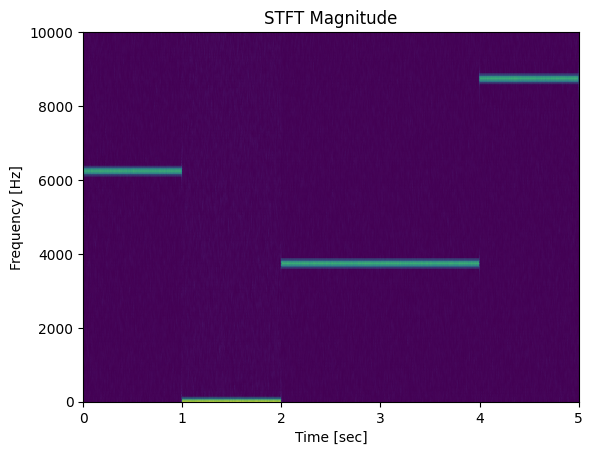

In [5]:
from scipy.signal import stft

# Calculate the stft of the waveform
f, k, Zxx = stft(signals, fs=sampling_rate, nperseg=256)
plt.pcolormesh(k, f, jnp.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [6]:
def binary_operator_diag(element_i, element_j):
    a_i, bu_i = element_i
    a_j, bu_j = element_j

    return a_j * a_i, a_j * bu_i + bu_j


def init_lru_parameters(N, H, r_min = 0.0, r_max = 1, max_phase = 6.28):
    # N: state dimension, H: model dimension
    # Initialization of Lambda is complex valued distributed uniformly on ring
    # between r_min and r_max, with phase in [0, max_phase].

    u1 = np.random.uniform(size = (N,))
    u2 = np.random.uniform(size = (N,))

    nu_log = np.log(-0.5*np.log(u1*(r_max**2-r_min**2) + r_min**2))
    theta_log = np.log(max_phase*u2)

    # Glorot initialized Input/Output projection matrices
    B_re = np.random.normal(size=(N,H))/np.sqrt(2*H)
    B_im = np.random.normal(size=(N,H))/np.sqrt(2*H)
    C_re = np.random.normal(size=(H,N))/np.sqrt(N)
    C_im = np.random.normal(size=(H,N))/np.sqrt(N)
    D = np.random.normal(size=(H,))

    # Normalization
    diag_lambda = np.exp(-np.exp(nu_log) + 1j*np.exp(theta_log))
    gamma_log = np.log(np.sqrt(1-np.abs(diag_lambda)**2))

    return nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log


def forward_LRU(lru_parameters, input_sequence):
    # Unpack the LRU parameters
    nu_log, theta_log, B_re, B_im, C_re, C_im, D, gamma_log = lru_parameters

    # Initialize the hidden state
    Lambda = jnp.exp(-jnp.exp(nu_log) + 1j*jnp.exp(theta_log))
    B_norm = (B_re + 1j*B_im) * jnp.expand_dims(jnp.exp(gamma_log), axis=-1)
    #print(B_norm.shape)
    C = C_re + 1j*C_im

    Lambda_elements = jnp.repeat(Lambda[None, ...], input_sequence.shape[0], axis=0)

    Bu_elements = jax.vmap(lambda u: B_norm @ u)(input_sequence)
    elements = (Lambda_elements, Bu_elements)
    _, inner_states = parallel_scan(binary_operator_diag, elements) # all x_k
    y = jax.vmap(lambda x, u: (C @ x).real + D * u)(inner_states, input_sequence)


    return y

In [7]:
def init_mlp_parameters(layers):
    # Initialize the MLP parameters
    parameters = []
    for i in range(len(layers)-1):
        W = np.random.normal(size=(layers[i], layers[i+1]))/np.sqrt(layers[i])
        b = np.zeros((layers[i+1],))
        parameters.append((W, b))

    return parameters

@jit
def forward_mlp(mlp_parameters, input, activation_function = jnp.tanh):
    # Forward pass of the MLP
    
    x = input

    for W, b in mlp_parameters:
        x = x @ W + b
        x = activation_function(x)

    return x

def forward_mlp_linear_with_classification(mlp_parameters, input, activation_function = jnp.tanh):
    
    x = input

    # Only apply the MLP up to the second last layer
    for W, b in mlp_parameters[:-1]:
        x = x @ W + b
        x = activation_function(x)

    # Apply the last layer without activation function
    W, b = mlp_parameters[-1]
    x = x @ W + b

    # Use the softmax function on the last layer
    x = jax.nn.softmax(x)


    return x

def layer_normalization(activations):
    mu  = jnp.mean(activations)
    sigma = jnp.std(activations)
    return (activations - mu) / sigma

layer_normalization_sequence = vmap(layer_normalization)

def max_pooling(sequence_to_pool):
    return jnp.max(sequence_to_pool, axis=0)

def mean_pooling(sequence_to_pool):
    return jnp.mean(sequence_to_pool, axis=0)

def sum_pooling(sequence_to_pool):
    return jnp.sum(sequence_to_pool, axis=0)

In [8]:
def model_forward(input_sequence, parameters):
    Linear_encoder_parameter,  LRU, seconday_parameters, Linear_decoder_parameter = parameters

    x = forward_mlp(Linear_encoder_parameter, input_sequence)
    skip = x
    x = layer_normalization_sequence(x)
    x = forward_LRU(LRU, x)
    x = forward_mlp(seconday_parameters, x) + skip
    x = max_pooling(x)
    x = forward_mlp_linear_with_classification(Linear_decoder_parameter, x)

    return x

# Batch model forward
batch_model_forward = vmap(model_forward, in_axes=(0, None))

def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jit
def loss_fn(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)

    # Binary cross entropy loss
    return -jnp.mean(jnp.sum(target_sequences * jnp.log(y), axis=1))

@jit
def model_grad(input_sequence, target_sequence, parameters):
    return grad(loss_fn, argnums=2)(input_sequence, target_sequence, parameters)

@jit
def parameter_update(parameters, gradients, learning_rate = 0.01):
    new_parameters = []
    im = []
    for parameter, gradient in zip(parameters[0], gradients[0]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[1], gradients[1]):
        im.append(parameter - learning_rate * gradient)    

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[2], gradients[2]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    im = []
    for parameter, gradient in zip(parameters[3], gradients[3]):
        im.append((parameter[0] - learning_rate * gradient[0], parameter[1] - learning_rate * gradient[1]))

    new_parameters.append(im)

    return new_parameters


@jit
def accuracy(input_sequences, target_sequences, parameters):
    y = batch_model_forward(input_sequences, parameters)
    return jnp.mean(jnp.argmax(y, axis=1) == jnp.argmax(target_sequences, axis=1))

batch_model_grad = vmap(model_grad, in_axes=(0, 0, None))

In [9]:
# Load model
with open('model_parameters.pkl', 'rb') as f:
    model_parameters = pkl.load(f)

model_parameters

{'Untrained': [[(array([[ 1.27823153, -0.42819644, -1.33519863,  0.36506289, -0.31110208]]),
    array([0., 0., 0., 0., 0.])),
   (array([[ 2.82711457e-01,  9.09702920e-02,  7.52326674e-02,
            -8.91150596e-01,  2.58069386e-01, -1.29860815e-01,
             1.46520124e-01,  2.33246898e-01, -9.47462152e-02,
             5.29764584e-01],
           [ 3.96867511e-01, -3.48267521e-01,  1.14560275e-01,
            -3.48131673e-01, -4.76111782e-01,  1.31457940e-01,
            -5.40633600e-01,  4.34251285e-04, -2.89606741e-01,
             6.48518577e-01],
           [ 3.02816675e-01, -4.64511359e-01, -1.10518664e+00,
             4.09889838e-01,  3.19704861e-01, -5.44139472e-01,
            -3.07210813e-01,  3.11898631e-01,  9.42900444e-01,
            -9.99449067e-01],
           [ 8.48548367e-02, -3.66312386e-01,  4.58042101e-01,
            -4.52702795e-01,  1.71493909e-01, -4.67593042e-01,
             1.56375062e-01, -4.86650439e-01,  1.04703457e+00,
             1.25015039e-01

In [10]:
selected_symbols = np.array([9,9,5,9,9])
signals = generate_five_signals(key, t, selected_symbols).reshape(n_samples,1)

Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0000001192092896
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 5 with frequency 6250.0
Power of signal 5: 1.0
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0


In [11]:
results = []
interval = []
for x in range(0, len(signals)-19000, 1000):
    input_sequence = signals[x:x+20000]

    print(model_forward(input_sequence, model_parameters["Epoch 4"]))
    results.append(model_forward(input_sequence, model_parameters["Epoch 4"]))
    interval.append(x)
    print(x, x+20000)

[3.0454649e-02 3.8456451e-04 2.8479442e-03 7.2068069e-04 3.2098780e-03
 2.2636356e-03 3.2073413e-03 6.7441505e-03 9.5016706e-01]
0 20000
[2.5502475e-02 3.7830134e-04 2.8153078e-03 7.1524648e-04 3.0278643e-03
 2.1506338e-03 2.8499218e-03 6.5497863e-03 9.5601052e-01]
1000 21000
[2.5371516e-02 3.6802323e-04 2.7637829e-03 7.1028364e-04 3.0334177e-03
 2.1334374e-03 2.8809290e-03 6.6058803e-03 9.5613265e-01]
2000 22000
[2.5371535e-02 3.6802370e-04 2.7637852e-03 7.1028358e-04 3.0334203e-03
 2.1334384e-03 2.8809288e-03 6.6058827e-03 9.5613259e-01]
3000 23000
[2.7798962e-02 3.4338931e-04 2.6029528e-03 7.2309212e-04 2.9370342e-03
 2.1966784e-03 3.2292053e-03 6.8128593e-03 9.5335591e-01]
4000 24000
[2.7798934e-02 3.4338882e-04 2.6029490e-03 7.2309136e-04 2.9370312e-03
 2.1966784e-03 3.2292036e-03 6.8128495e-03 9.5335591e-01]
5000 25000
[2.5816681e-02 2.9932923e-04 2.2870458e-03 7.8890700e-04 2.4858434e-03
 2.0369710e-03 3.4614753e-03 7.4302168e-03 9.5539361e-01]
6000 26000
[2.5816668e-02 2.993292

Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0000001192092896
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 5 with frequency 6250.0
Power of signal 5: 1.0
Generating signal 9 with frequency 8750.0
Power of signal 9: 0.9999998807907104
Generating signal 9 with frequency 8750.0
Power of signal 9: 1.0


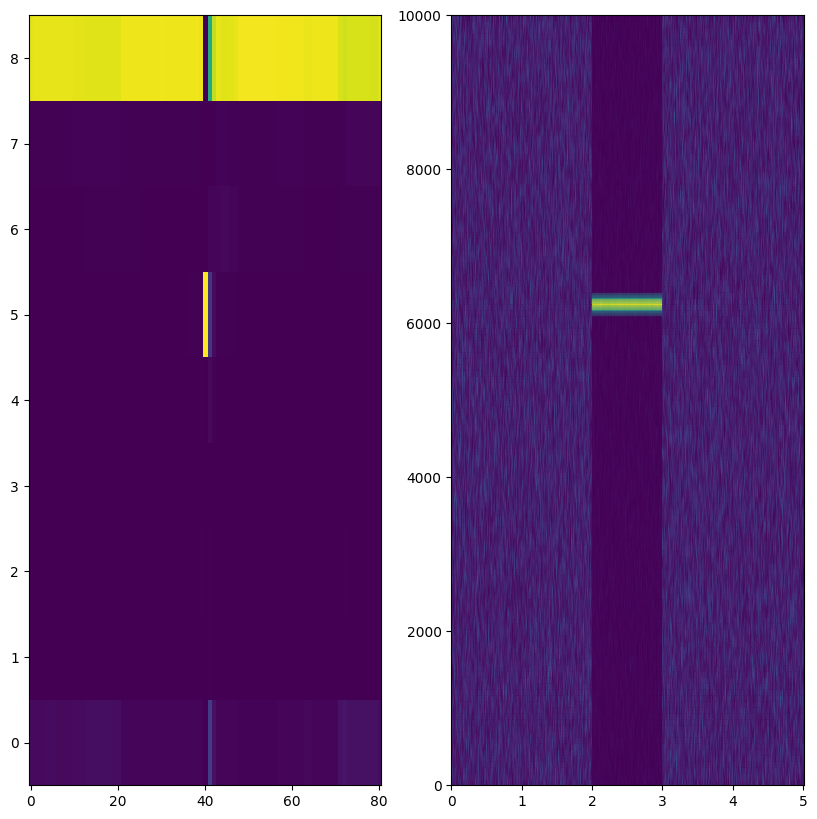

In [12]:
# Make a heatmap of the results
results = jnp.array(results)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)

ax.imshow(results.T, aspect='auto')
ax.invert_yaxis()
ax2 = fig.add_subplot(1,2,2)
from scipy.signal import stft

# Calculate the stft of the waveform
f, k, Zxx = stft(generate_five_signals(key, t, selected_symbols), fs=sampling_rate, nperseg=256)
ax2.pcolormesh(k, f, jnp.abs(Zxx), shading='gouraud')

Generating signal 1 with frequency 1250.0
Power of signal 1: 1.0
Generating signal 2 with frequency 2500.0
Power of signal 2: 1.0000001192092896
Generating signal 3 with frequency 3750.0
Power of signal 3: 1.0000001192092896
Generating signal 4 with frequency 5000.0
Power of signal 4: 0.9999998807907104
Generating signal 5 with frequency 6250.0
Power of signal 5: 1.0
[2.2747810e-03 9.8647261e-01 3.6875957e-03 3.1845104e-03 4.4202512e-05
 4.2010969e-03 3.0072099e-06 3.5274452e-06 1.2863905e-04]
0 20000
[2.50277426e-02 6.52498081e-02 8.68373334e-01 1.21428944e-04
 2.66635995e-02 3.92853003e-03 2.66688294e-05 3.56793869e-04
 1.02520548e-02]
1000 21000
[2.55762488e-02 6.56681955e-02 8.66236091e-01 1.21874225e-04
 2.75154989e-02 4.07316815e-03 2.76665851e-05 3.57907120e-04
 1.04232775e-02]
2000 22000
[2.55762357e-02 6.56681731e-02 8.66236091e-01 1.21874225e-04
 2.75154989e-02 4.07316582e-03 2.76666105e-05 3.57907295e-04
 1.04232775e-02]
3000 23000
[2.55762488e-02 6.56681955e-02 8.66236091e-

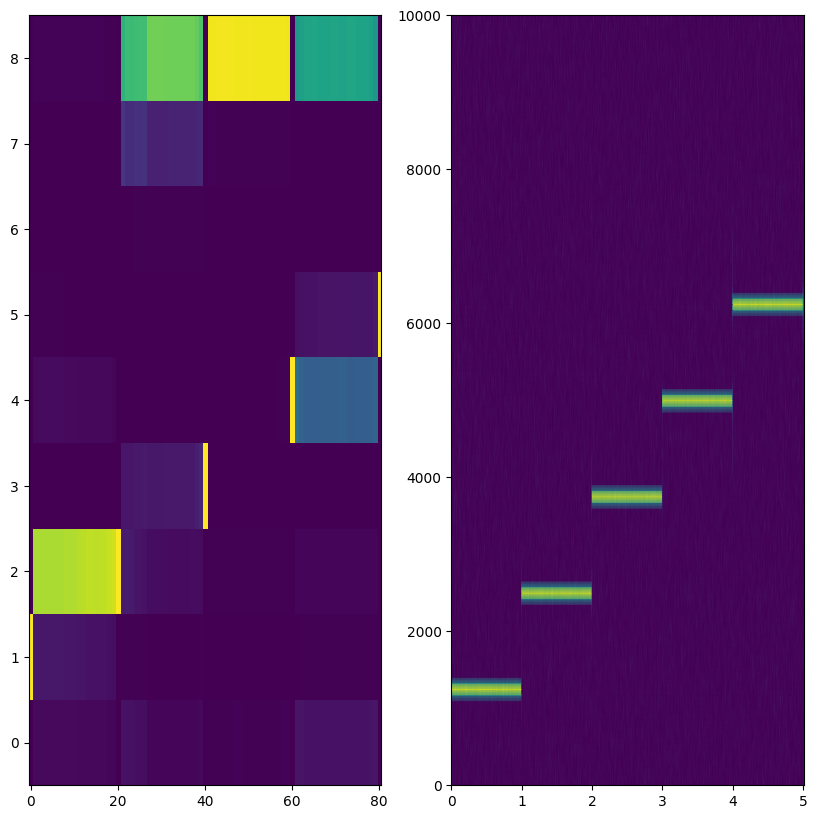

In [13]:
selected_symbols= np.array([1,2,3,4,5])
signals = generate_five_signals(key, t, selected_symbols).reshape(n_samples,1)

results = []
interval = []
for x in range(0, len(signals)-19000, 1000):
    input_sequence = signals[x:x+20000]

    print(model_forward(input_sequence, model_parameters["Epoch 4"]))
    results.append(model_forward(input_sequence, model_parameters["Epoch 4"]))
    interval.append(x)
    print(x, x+20000)

# Make a heatmap of the results
results = jnp.array(results)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)

ax.imshow(results.T, aspect='auto')
ax.invert_yaxis()
ax2 = fig.add_subplot(1,2,2)
from scipy.signal import stft

# Calculate the stft of the waveform
f, k, Zxx = stft(generate_five_signals(key, t, selected_symbols), fs=sampling_rate, nperseg=256)
ax2.pcolormesh(k, f, jnp.abs(Zxx), shading='gouraud')